In [1]:
import numpy as np
from scipy.fft import fft, ifft, fftfreq
import matplotlib.pyplot as plt
from PyOctaveBand import getansifrequencies
from math import sqrt
from hos import HOS

In [2]:
# Sample rate and duration
fs = pow(2,18)
duration = 5  # In seconds
N = np.round(fs * duration)
print(N)

# Time array
x = np.arange(np.round(fs * duration)) / fs

print(x[pow(2,14)], 1/20)

1310720
0.0625 0.05


In [3]:
def signal(x):
    # Signal with 6 frequencies
    f1, f2, f3, f4, f5, f6 = 20, 100, 500, 2000, 4000, 15000
    # Multi Sine wave signal
    return 100 \
        * (np.sin(2 * np.pi * f1 * x)
           + np.sin(2 * np.pi * f2 * x)
           + np.sin(2 * np.pi * f3 * x)
           + np.sin(2 * np.pi * f4 * x)
           + np.sin(2 * np.pi * f5 * x)
           + np.sin(2 * np.pi * f6 * x))

def rumore(x):
    return np.random.normal(size=len(x)) * 1000

def plot_spectrum(frq, spec):
    plt.figure(figsize=(20,3))
    plt.plot(frq, spec)

    plt.xscale('log')
    plt.grid()

    plt.show()
    
def plot_signal(x, signal):
    plt.figure(figsize=(20,3))
    plt.plot(x[:500], signal[:500])
    
    plt.grid()

    plt.show()
    
def fft_bucket(left, right, fft_frq):
    indexes = []
    for idx,f in enumerate(fft_frq):
        if left <= f and f <= right:
            indexes.append(idx)
        if f > right:
            break
    return indexes

def third_octave_spec(time, signal, window_size, avg, plot_fft=False, pl_signal=False):
    if pl_signal:
        plot_signal(time, signal)
    
    if avg == -1 or avg is None:
        transform = fft(signal)
        frq = fftfreq(N, 1/fs)
        end_of_positive_frequencies = int(N // 2)
        
        xf = frq[:end_of_positive_frequencies]
        spec = np.abs(transform[:end_of_positive_frequencies])
    else:
        h = HOS(x,signal, window_size=window_size)
        a,b = h.spectrum(avg)

        end_of_positive_frequencies = len(b) // 2 - 1
        xf = b[:end_of_positive_frequencies]
        spec = a[:end_of_positive_frequencies]
    
    if plot_fft:
        plot_spectrum(xf, spec)
    
    center, left, right = getansifrequencies(fraction=3)
    center = np.array(center)
    buckets = list(map(lambda tp: fft_bucket(tp[0], tp[1], xf), zip(left, right)))
    
    amplitudes = []
    for b in buckets:
        amplitudes.append(sqrt(sum([pow(spec[i],2) for i in b])))
        
    return center, amplitudes

def plot_octave_spectrum(center, amplitudes, db=True, label=None):
    plt.figure(figsize=(20,5.5))

    plt.xscale('log')
    if not db:
        plt.yscale('log')
    
    if label is None:
        plt.plot(center, 20*np.log10(amplitudes) if db else amplitudes)
    else:
        if isinstance(label, str):
            plt.plot(center, 20*np.log10(amplitudes) if db else amplitudes, label=label)
        elif isinstance(label, list):
            for c,a,l in zip(center, amplitudes, label):
                plt.plot(c, 20*np.log10(a) if db else a, label=l, marker='.')
        plt.legend()
        center = center[0]

    plt.grid()
    
    plt.xlabel('f')
    if db:
        plt.ylabel('Db')
    
    fs_label = '{' + str(np.log2(fs)) + '}'
    plt.title('"A mano"       fs=$2^{}$ Hz, T={} seconds, N=$2^{}$ x {}={}'.format(fs_label,duration,fs_label,duration,N))

    idxes = [i % 2 == 0 for i in range(len(center))]
    plt.xticks(center[idxes], np.round(center[idxes],2))

    plt.show()
    
def experiment(ws, avg, r=False):
    return third_octave_spec(x, signal(x) + rumore(x) if r else 0, window_size=pow(2,ws), avg=avg)

def label(tp):
    if tp[1] is None:
        return 'No HOS'
    return 'window=$2^{}$, avg={}'.format('{' + str(tp[0]) + '}', tp[1])

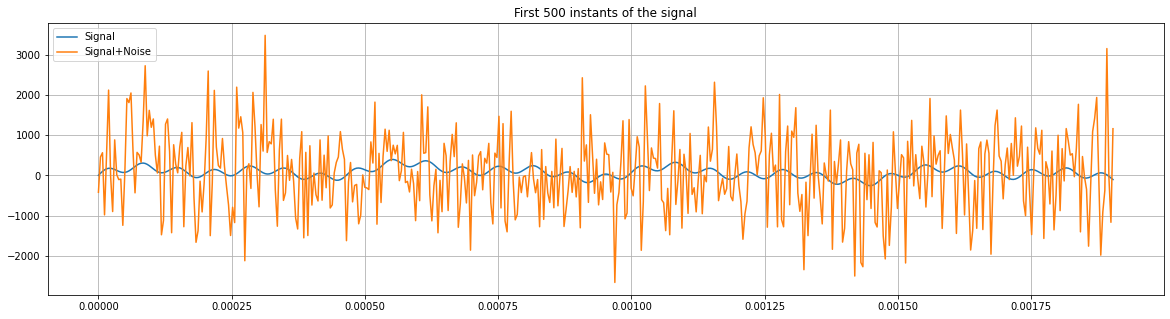

In [4]:
plt.figure(figsize=(20,5))

n = 500

r = rumore(x)

plt.plot(x[:n],signal(x[:n]), label='Signal')
plt.plot(x[:n],signal(x[:n]) + r[:n], label='Signal+Noise')

plt.grid()
plt.title('First {} instants of the signal'.format(n))

plt.legend()

plt.show()

In [5]:
tps = [(16,10), (16,100), (16,1000), (0,None)]
labels = list(map(label, tps))
results = map(lambda tp: experiment(*tp, r=True), tps)
centers, amplitudes = zip(*list(results))

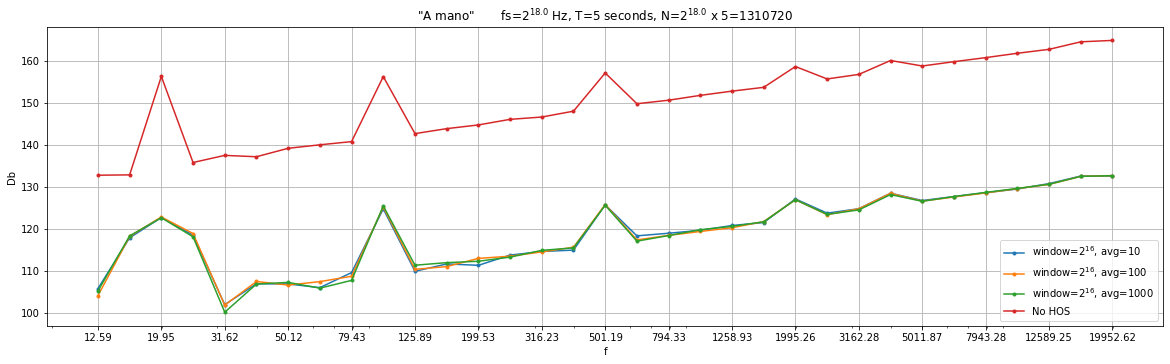

In [6]:
plot_octave_spectrum(centers, amplitudes, label=labels)

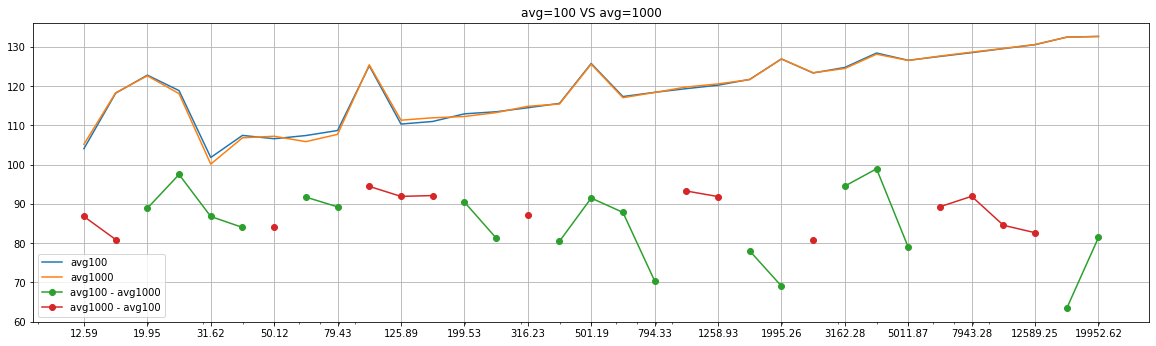

In [8]:
plt.figure(figsize=(20,5.5))

a1 = np.array(amplitudes[1])
a2 = np.array(amplitudes[2])

more100 = a1 - a2
more100[a1 < a2] = np.nan

more1000 = a2 - a1
more1000[a2 < a1] = np.nan

plt.plot(centers[1], 20*np.log10(a1), label='avg100')
plt.plot(centers[2], 20*np.log10(a2), label='avg1000')
plt.plot(centers[2], 20*np.log10(more100), marker='o', label='avg100 - avg1000')
plt.plot(centers[2], 20*np.log10(more1000), marker='o', label='avg1000 - avg100')

plt.grid()
plt.xscale('log')

idxes = [i % 2 == 0 for i in range(len(centers[2]))]
plt.xticks(centers[2][idxes], np.round(centers[2][idxes],2))

plt.legend()

plt.title('avg=100 VS avg=1000')

plt.show()